# Loading the SPIDER dataset from HuggingFace

This tutorial will walk you through the steps to download and use the SPIDER dataset.

### Table of Contents

1. [Installing Dependencies](#dependencies)
2. [Loading Demo Dataset](#demo_config)
3. [Visualizing an Example Image](#visualizing_image)
4. [Resizing Images](#resizing)
5. [Loading Original Images](#original_images)
6. [Extracting Metadata](#metadata)
7. [Filtering Scan Types](#filter_scan_type)
8. [Loading Full Dataset](#loading_full_dataset)


### Installing Dependencies <a name="dependencies"></a>

First, install the necessary dependencies:

In [1]:
!pip install datasets -q
!pip install scikit-image -q
!pip install SimpleITK -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 19.6 MB/s eta 0:00:00


In [2]:
import datasets
import skimage
import SimpleITK as sitk

print(f'datasets: {datasets.__version__}')
print(f'scikit-image: {skimage.__version__}')
print(f'SimpleITK: {sitk.__version__}')

datasets: 2.19.0
scikit-image: 0.19.3
SimpleITK: 2.3.1


### Loading the Dataset with Demo Configuration <a name="demo_config"></a>

Next, use the `load_dataset` function from the `datasets` library to download the data directly from the [Zenodo](https://zenodo.org/records/10159290) repository.

Select the `demo` configuration to verify that the function works as intended. The `demo` configuration downloads all of the original `.mha` image and mask files from Zenodo, but only processes the first 10 examples to reduce computation time. The downloaded `.mha` image files will be saved to cache on your local system (which you can set with the `cache_dir` parameter -- see the HuggingFace [docs](https://huggingface.co/docs/datasets/v2.18.0/en/package_reference/loading_methods#datasets.load_dataset)).

Note that in future versions of the `load_dataset` function, you will have to
explicitly pass `trust_remote_code=True` for the code to run. You can review
the source code in the HuggingFace repository [here](https://huggingface.co/datasets/cdoswald/SPIDER/blob/main/SPIDER.py).

In [3]:
from datasets import load_dataset
dataset = load_dataset("cdoswald/SPIDER", name="demo", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Notice that the dataset is split into train, validation, and test subsets, and each example has 8 features: `patient_id`, `scan_type`, `image`, `mask`, `image_path`, `mask_path`, `metadata`, and `rad_gradings`. Only the first 10 examples were processed for this `demo` configuration.

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'scan_type', 'image', 'mask', 'image_path', 'mask_path', 'metadata', 'rad_gradings'],
        num_rows: 10
    })
    validation: Dataset({
        features: ['patient_id', 'scan_type', 'image', 'mask', 'image_path', 'mask_path', 'metadata', 'rad_gradings'],
        num_rows: 10
    })
    test: Dataset({
        features: ['patient_id', 'scan_type', 'image', 'mask', 'image_path', 'mask_path', 'metadata', 'rad_gradings'],
        num_rows: 10
    })
})

### Visualizing an Example Image <a name="visualizing_image"></a>

We can view the features for a specific example by first selecting the data subset (e.g., "train") and then indexing a particular observation:

In [5]:
example = dataset['train'][3]
print(f'Patient ID: {example["patient_id"]}\nScan type: {example["scan_type"]}')

Patient ID: 173
Scan type: t2


By default, the `image` and `mask` attributes will each be a sequence of 2D grayscale images of size `(512, 512)`. The length of the sequence will depend on the number of images available along the depth dimension, which tends to vary for each scan. For example, a scan for one patient may have 10 images in the sequence, while the scan for another patient may have 120.


In [6]:
seq_lens = []
for i in range(len(dataset['train'])):
    seq_lens.append(len(dataset['train'][i]['image']))
print(f'Sequence lengths for demo dataset: {seq_lens}')

Sequence lengths for demo dataset: [24, 14, 17, 15, 17, 19, 24, 120, 18, 15]


We can select a few specific depths to display as 2D images using matplotlib's `imshow` function:

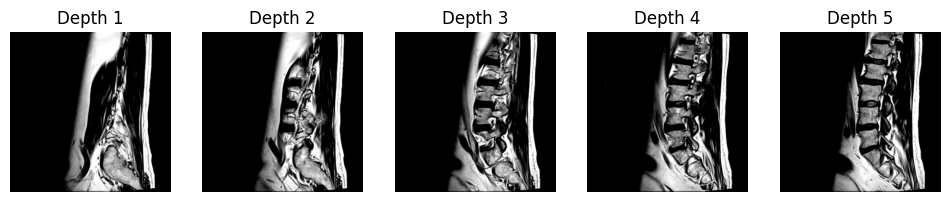

In [7]:
import matplotlib.pyplot as plt

show_n = 5

if len(example['image']) < show_n:
    show_n = len(example['image'])

fig, ax = plt.subplots(1, show_n, figsize=(12, 8))
for j in range(show_n):
    ax[j].imshow(example['image'][j], cmap='gray', origin='lower')
    ax[j].set_title(f'Depth {j+1}')
    ax[j].axis('off')
plt.show();

We can also overlay the segmentation masks on the images. But first we need to define a colormap based on the values used in the original research paper:

- 0 = background
- 1-25 = vertebrae (numbered from the bottom, i.e., L5 = 1)
- 100 = spinal canal
- 101-125 = partially visible vertebrae
- 201-225 = intervertebral discs (numbered from the bottom, i.e., L5/S1 = 201)

Refer to the [SPIDER Grand Challenge](https://grand-challenge.org/algorithms/spider-baseline-iis/) documentation for more details.

You can define a more clever colormap, but for this tutorial we'll use the same color for all of the anatomical structures within the same category.

**IMPORTANT**: The segmentation masks loaded via the `load_dataset` function may contain integer values that fall outside of the ranges mentioned above. This is probably related to the HuggingFace data serialization process (e.g., converting to Apache Arrow format) since the locally cached original masks don't have the same issue.

You can check specific masks with the following code:

In [8]:
import numpy as np
import pandas as pd

unique_vals, unique_counts = np.unique(np.array(example['mask']), return_counts=True)
pd.DataFrame({'mask_value':unique_vals, 'pixel_count':unique_counts})

,mask_value,pixel_count
0,0,3675503
1,1,35909
2,2,35754
3,3,35897
4,4,32056
5,5,26730
6,6,14427
7,100,34670
8,201,6692
9,202,9347


If this issue occurs, one option is to modify the ranges slightly to ignore any artifacts:

- 0 = background
- 1 - 90 = vertebrae
- 91 - 100 = spinal canal
- 101 - 190 = partially visible vertebrae
- 191 - 225 = intervertebral discs

(Or you'd prefer, you can load the original MRI images and masks--see *Loading the Original Images* section below.)


In [9]:
from matplotlib.colors import ListedColormap
colors = (
    ['none'] +
    ['chartreuse'] * 90 +
    ['cyan'] * 10 +
    ['orange'] * 80 +
    ['magenta'] * 35
)
cmap = ListedColormap(colors, name='custom_categorical_cmap')

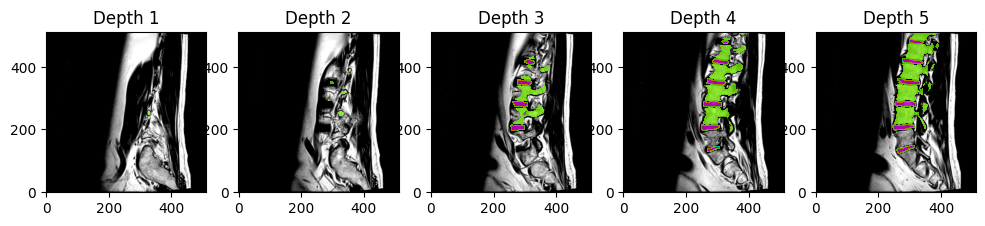

In [10]:
fig, ax = plt.subplots(1, show_n, figsize=(12, 8))
for j in range(show_n):
    ax[j].imshow(example['image'][j], cmap='gray', origin='lower')
    ax[j].imshow(
        example['mask'][j], alpha=0.7, cmap=cmap, vmin=0, vmax=225, origin='lower'
    )
    ax[j].set_title(f'Depth {j+1}')
plt.show();

### Setting a Custom Resize Shape <a name="resizing"></a>

Notice that the default shape of the example image and mask is `(512, 512)`. Additionally, the resolution (i.e., pixel intensity) is limited to the range `[0, 6192]`. The original images vary significantly in size and resolution, and were therefore resized and rescaled to allow the dataset to be loaded via the HuggingFace `datasets` library.

In [11]:
print(f'Image shape: {np.array(example["image"][0]).shape}')
print(f'Mask shape: {np.array(example["mask"][0]).shape}')
print(f'Image pixel range: [{np.array(example["image"]).min()}, {np.array(example["image"]).max()}]')
print(f'Mask pixel range: [{np.array(example["mask"]).min()}, {np.array(example["mask"]).max()}]')

Image shape: (512, 512)
Mask shape: (512, 512)
Image pixel range: [0, 6192]
Mask pixel range: [0, 206]


If you would prefer a different default size, you can pass a 2-tuple of integers indicating `(height, width)` to the `resize_shape` parameter as follows:



In [12]:
resize_shape = (256, 256)
new_dataset = load_dataset(
    "cdoswald/SPIDER", name="demo", resize_shape=resize_shape, trust_remote_code=True
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [13]:
new_example = new_dataset["train"][3]
print(f'New image shape: {np.array(new_example["image"][0]).shape}')
print(f'New mask shape: {np.array(new_example["mask"][0]).shape}')

New image shape: (256, 256)
New mask shape: (256, 256)


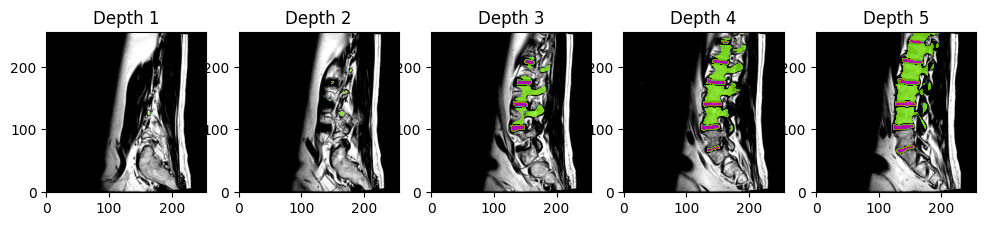

In [14]:
fig, ax = plt.subplots(1, show_n, figsize=(12, 8))
for j in range(show_n):
    ax[j].imshow(new_example['image'][j], cmap='gray', origin='lower')
    ax[j].imshow(
        new_example['mask'][j], alpha=0.7, cmap=cmap, vmin=0, vmax=225, origin='lower'
    )
    ax[j].set_title(f'Depth {j+1}')
plt.show();

### Loading the Original Images (Size and Resolution) <a name="original_images"></a>

Unfortunately, there is **not** currently a parameter to set a custom resolution. If you would prefer to use the resolution or size of the original images, and/or resize and rescale them to meet your specific requirements, you can import the original image and mask for each example using the `SimpleITK` library:

In [15]:
orig_image = sitk.ReadImage(example['image_path'])
orig_image_array = sitk.GetArrayFromImage(orig_image)

orig_mask = sitk.ReadImage(example['mask_path'])
orig_mask_array = sitk.GetArrayFromImage(orig_mask)

print(f'Original image shape: {orig_image_array.shape}')
print(f'Original mask shape: {orig_mask_array.shape}')

Original image shape: (384, 384, 15)
Original mask shape: (384, 384, 15)


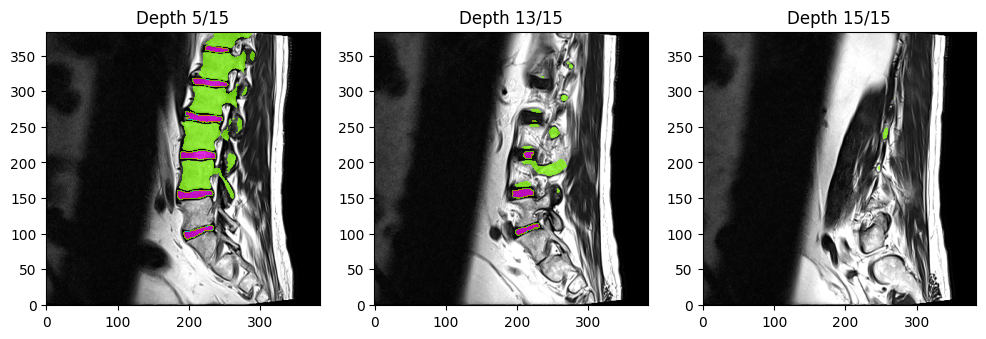

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
for j, depth in enumerate([4, 12, 14]):
    ax[j].imshow(orig_image_array[:, :, depth], cmap='gray', origin='lower')
    ax[j].imshow(orig_mask_array[:, :, depth], alpha=0.7, cmap=cmap, vmin=0, vmax=225, origin='lower')
    ax[j].set_title(f'Depth {depth+1}/{orig_mask_array.shape[-1]}')
plt.show();

### Extracting Metadata <a name="metadata"></a>

In addition to the MRI image and segmentation mask data, each example includes metadata related to the scanner and patient characteristics, when available. You can access this information through the `metadata` feature:

In [17]:
example['metadata']

{'num_vertebrae': 6,
 'num_discs': 6,
 'sex': 'M',
 'birth_date': '',
 'AngioFlag': 'N',
 'BodyPartExamined': 'LSPINE',
 'DeviceSerialNumber': '141639.0',
 'EchoNumbers': 1.0,
 'EchoTime': 97.0,
 'EchoTrainLength': 19.0,
 'FlipAngle': 150.0,
 'ImagedNucleus': '1H',
 'ImagingFrequency': 63.67683792114258,
 'InPlanePhaseEncodingDirection': 'COL',
 'MRAcquisitionType': '2D',
 'MagneticFieldStrength': 1.5,
 'Manufacturer': 'SIEMENS',
 'ManufacturerModelName': 'Aera',
 'NumberOfPhaseEncodingSteps': 494,
 'PercentPhaseFieldOfView': 100.0,
 'PercentSampling': 70.0,
 'PhotometricInterpretation': 'MONOCHROME2',
 'PixelBandwidth': 195,
 'PixelSpacing': '[0.72916668653488, 0.72916668653488]',
 'RepetitionTime': 3500.0,
 'SAR': 1.4634144346974998,
 'SamplesPerPixel': 1,
 'ScanningSequence': 'SE',
 'SequenceName': '*tseR2d1rr19',
 'SeriesDescription': 'SAG T2 TSE',
 'SliceThickness': 4.0,
 'SoftwareVersions': 'syngo MR E11',
 'SpacingBetweenSlices': 4.800000190734863,
 'SpecificCharacterSet': 'ISO_

Similarly, radiological gradings can be accessed through the `rad_gradings` feature:

In [18]:
example['rad_gradings']

{'IVD label': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
 'Modic': ['', '2', '0', '0', '2', '2', '0', '', '', ''],
 'UP endplate': ['', '1', '1', '0', '1', '1', '0', '', '', ''],
 'LOW endplate': ['', '1', '1', '0', '1', '1', '0', '', '', ''],
 'Spondylolisthesis': ['', '0', '0', '0', '0', '0', '0', '', '', ''],
 'Disc herniation': ['', '1', '0', '0', '0', '0', '0', '', '', ''],
 'Disc narrowing': ['', '1', '0', '0', '0', '0', '0', '', '', ''],
 'Disc bulging': ['', '0', '1', '0', '1', '0', '0', '', '', ''],
 'Pfirrman grade': ['', '3', '2', '2', '3', '2', '2', '', '', '']}

More information about interpreting the radiological gradings data can be found in the [original paper](https://www.nature.com/articles/s41597-024-03090-w).

### Filtering by Scan Type <a name="filter_scan_type"></a>

The original dataset contains T1, T2, and T2-SPACE [scan types](https://case.edu/med/neurology/NR/MRI%20Basics.htm). You can filter for a subset of scan types by passing a list of the desired types to the `scan_types` parameter:

In [19]:
scan_types = ["t1", "t2"] # Exclude "t2_SPACE" scan types
dataset = load_dataset(
    "cdoswald/SPIDER", name="demo", scan_types=scan_types, trust_remote_code=True
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [20]:
all_scan_types = [example['scan_type'] for example in dataset['train']]
print(f'Unique scan types: {set(all_scan_types)}')

Unique scan types: {'t1', 't2'}


### Loading the Full Dataset <a name="loading_full_dataset"></a>

Finally, you can load all 447 examples (218 patients) using the `default` configuration, changing the other parameters as needed:




In [21]:
dataset = load_dataset(
    "cdoswald/SPIDER",
    name="default", # Default configuration loads all 447 examples
    scan_types=["t1", "t2", "t2_SPACE"], # Default includes all scan types
    resize_shape=(512, 512), # Default resizes images to 512h x 512w
    shuffle=True,
    trust_remote_code=True,
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]